# Praca domowa 6

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_olivetti_faces

## Wczytanie danych

In [2]:
data = fetch_olivetti_faces(return_X_y=False)

In [3]:
print(data.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [4]:
X = data.data
X.shape

(400, 4096)

In [5]:
def reshape(X):
    return X.reshape(X.shape[0], 64, 64)

In [26]:
X_train = X[:390, ]
X_test = X[390:400, ]

sd_scaler = StandardScaler()
sd_scaler.fit(X_train)
X_train = sd_scaler.transform(X_train)
X_test = sd_scaler.transform(X_test)

In [7]:
def plot_faces(data, n_faces=4):
    _, axes = plt.subplots(nrows=1, ncols=n_faces, figsize=(10, 3))
    for ax, image in zip(axes, data):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest', vmax=3, vmin=-3)

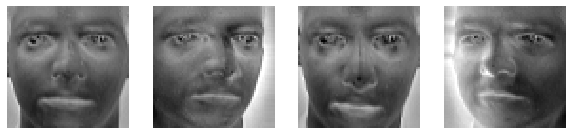

In [27]:
plot_faces(reshape(X_train))

## Kompresja

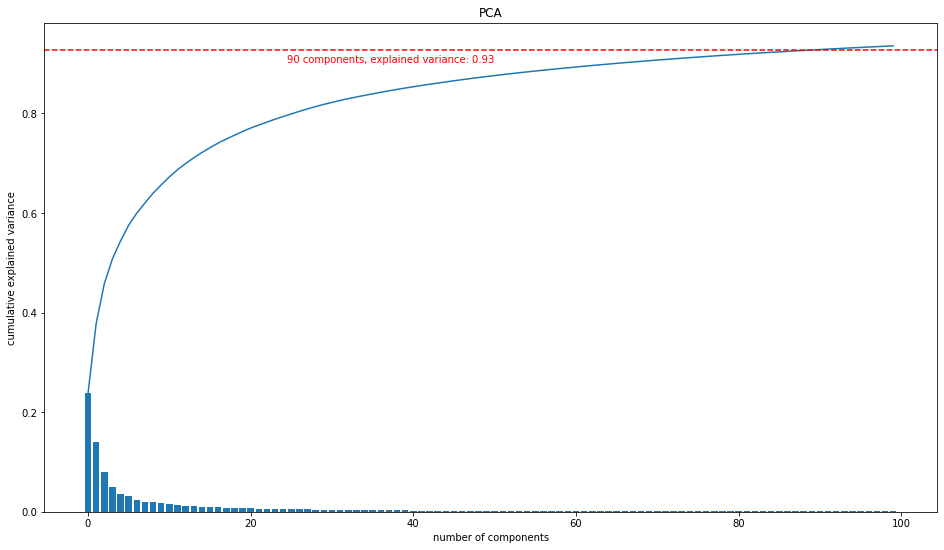

In [28]:
pca = PCA(random_state=1)
pca.fit(X)
explained_variance = pca.explained_variance_ratio_
n = 100
m = 90
m_comp_explained_variance = np.sum(explained_variance[0:m+1])

plt.rcParams["figure.figsize"] = [16,9]
plt.plot(np.cumsum(explained_variance[0:n]))
plt.bar(np.arange(n), explained_variance[0:n])
plt.axhline(y=m_comp_explained_variance, color="r", linestyle="dashed")
plt.text(50,m_comp_explained_variance-0.02, 
         str(m) + " components, explained variance: " + "{:.2f}".format(m_comp_explained_variance), 
         color="red", 
        ha="right", va="center")
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance");
plt.title("PCA")
plt.show()

In [29]:
pca = PCA(n_components = 90, random_state=1)
pca.fit(X_train)
X_pca = pca.transform(X_train)
X_hat = np.dot(X_pca, pca.components_) + pca.mean_

In [11]:
print(f"Compress ratio: {4096/90:.2f}")

Compress ratio: 45.51


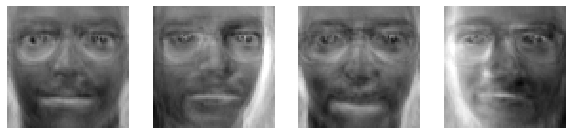

In [70]:
plot_faces(reshape(X_hat))
# 90 komponentów PCA dają znaczący stopień kompresji
# i można z nich odrestaurować obrazy o akceptowalnej jakości

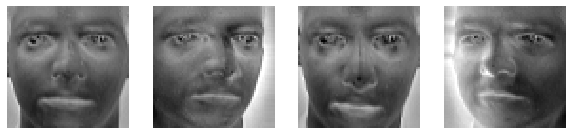

In [71]:
plot_faces(reshape(X_train))

In [14]:
def get_errors(X, X_hat):
    errors = np.zeros(X.shape[0])
    for i in range(len(errors)):
        errors[i] = mean_squared_error(X[i], X_hat[i], squared=False)
    return errors

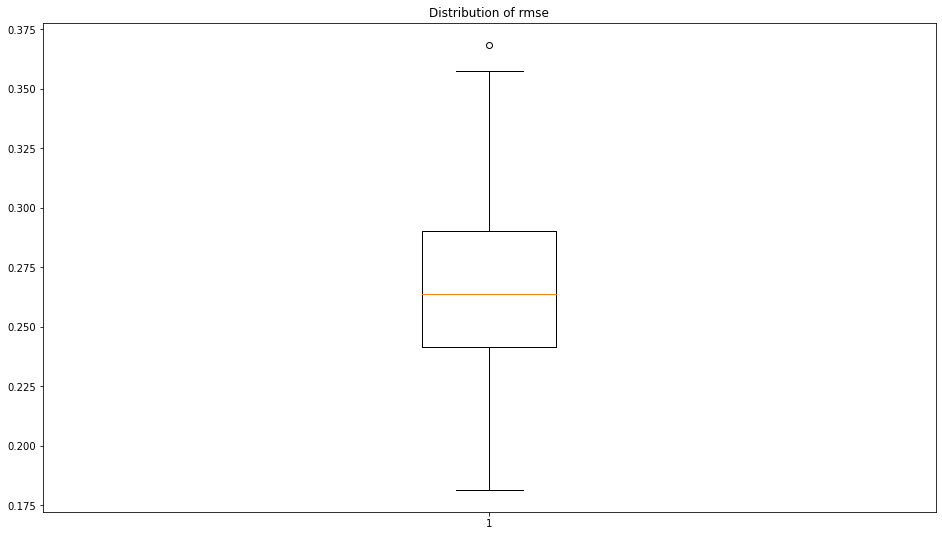

In [32]:
plt.boxplot(get_errors(X_train, X_hat))
plt.title("Distribution of rmse")
plt.show()

## Zmodyfikowane obrazy

In [18]:
kernel = np.ones((3,3),np.float32)/9

modifications = [
    lambda x: cv2.rotate(x.reshape((64, 64)), cv2.ROTATE_90_CLOCKWISE),
    lambda x: cv2.flip(x.reshape((64, 64)), -1),
    lambda x: cv2.filter2D(x.reshape((64, 64)), -1, kernel)
]

In [68]:
X_test_modified = np.empty((10, 4096))
for i in range(10):
    X_test_modified[i] = modifications[i%3](X_test[i]).reshape(4096)

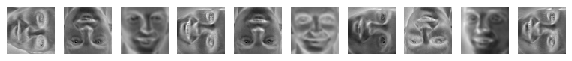

In [69]:
plot_faces(reshape(X_test_modified), 10)

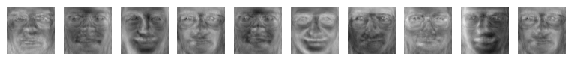

In [73]:
X_test_modified_pca = pca.transform(X_test_modified)
X_test_modified_hat = np.dot(X_test_modified_pca, pca.components_) + pca.mean_

plot_faces(reshape(X_test_modified_hat), 10)

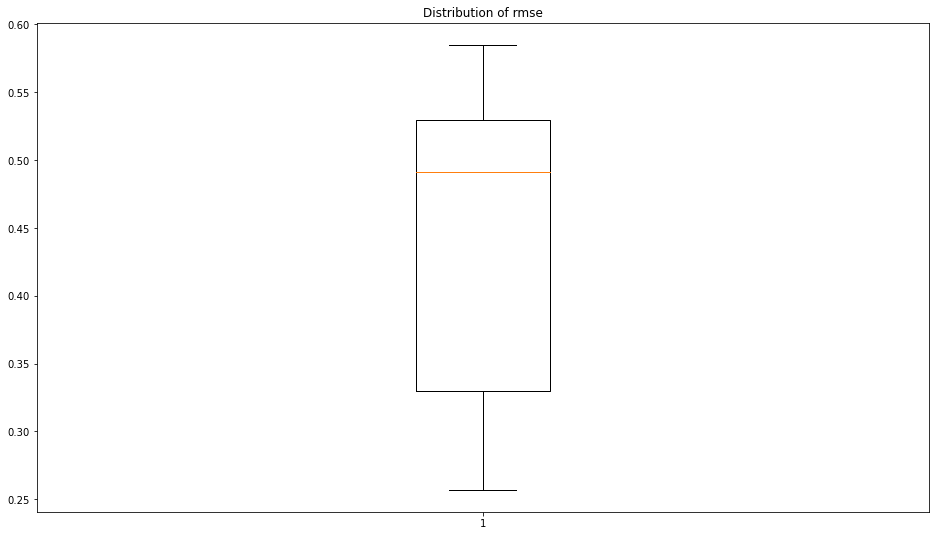

In [75]:
plt.boxplot(get_errors(X_test_modified, X_test_modified_hat))
plt.title("Distribution of rmse")
plt.show()